In [5]:
import numpy as np
import math as ma
import matplotlib.pyplot as plt
from numpy import linalg as LA
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy import optimize
import random
from functools import partial
from multiprocessing import Pool
import time

In [87]:
speciesNames=["NO", "NO2", "O2", "O3", "O3P"];
ratesNames = ["y1","y2","y3"]


getElemInd = {speciesNames[l]: l for l in range(len(speciesNames))}
getRateInd = {ratesNames[l]: l for l in range(len(ratesNames))}

nSpecies = len(speciesNames)
nRates = len(ratesNames)

constantSpecies = np.zeros((nSpecies))

constantSpecies[getElemInd['O2']]=1

constantSpeciesList=[]
constantSpeciesList.append('O2')


In [88]:
Temp=288.15;

pres=101325;

cair=pres/1.3807e-17/Temp;

cfactor = 2.550000e+10;

concO2 = 0.21*cair;

# tOffset=12*3600

tOffset=4*3600


#molec/cm^{3} 


initState=np.zeros((nSpecies))

# initState[getElemInd["O2"]] = concO2;

# initState[getElemInd["O2"]] = concO2;

# initState[getElemInd["O3"]] = 40*cfactor;

initState[getElemInd["O3P"]] = 0;
initState[getElemInd["NO"]] = 1.3*10**8;
initState[getElemInd["NO2"]] = 5.0*10**11;
initState[getElemInd["O3"]] = 8.0*10**11;

initState[getElemInd["O2"]] = concO2;


srcDef=np.zeros((nSpecies))
srcDef[getElemInd["NO"]] =  10**6;

In [89]:
def prod(prevState,rates):
    
    expFactor = np.zeros((nSpecies))
    
    
    
    NOPrev = prevState[0];
    NO2Prev = prevState[1];
    O2Prev = prevState[2];
    O3Prev = prevState[3];
    O3PPrev = prevState[4];
    
    y1 = rates[0];
    y2 = rates[1];
    y3 = rates[2];
    
#     print(rates)
    
#     print([NOPrev,NO2Prev,O3Prev,O3PPrev])
    
    NOExp = NO2Prev*y1;
    NO2Exp = NOPrev*O3Prev*y3;
    O2Exp = NOPrev*O3Prev*y3;
    O3Exp = O2Prev*O3PPrev*y2;
    O3PExp = NO2Prev*y1;
    
#     print([O2Prev,O3PPrev,y2,O2Prev*O3PPrev*y2])
    

    
    expFactor[0] = NOExp;
    expFactor[1] = NO2Exp;
    expFactor[2] = O2Exp;
    expFactor[3] = O3Exp;
    expFactor[4] = O3PExp;

    return expFactor;



def destr(prevState,rates):
    
    expFactor = np.zeros((nSpecies))
    
    NOPrev = prevState[0];
    NO2Prev = prevState[1];
    O2Prev = prevState[2];
    O3Prev = prevState[3];
    O3PPrev = prevState[4];

    y1 = rates[0];
    y2 = rates[1];
    y3 = rates[2];
    
    NOExp = O3Prev*y3;
    NO2Exp = y1;
    O2Exp = O3PPrev*y2;
    O3Exp = NOPrev*y3;
    O3PExp = O2Prev*y2;
    
    expFactor[0] = NOExp;
    expFactor[1] = NO2Exp;
    expFactor[2] = O2Exp;
    expFactor[3] = O3Exp;
    expFactor[4] = O3PExp;

    return expFactor;

In [90]:
def prodCalc(prevState,rates):
    
    res=prod(prevState,rates);
    
    for spec in constantSpeciesList:
        res[getElemInd[spec]]=0
    
    return res

def destCalc(prevState,rates):
    
    res=destr(prevState,rates);
    
    for spec in constantSpeciesList:
        res[getElemInd[spec]]=0
    
    return res

In [91]:
def makeRates(t):
    
    rate = np.zeros((nRates))
    
    th=(t+tOffset)/3600;

    curHourDecimal = th-24*ma.floor(th/24);


    if ((curHourDecimal > 4) and (curHourDecimal <20)):       
        rate[0]=(1e-5)*ma.exp(7.0*pow(ma.sin((ma.pi/16)*(curHourDecimal-4)),0.2));
    else:
        rate[0]=1e-40;

    rate[1]=(1e+5)/concO2;
    rate[2]=1e-16;
    
    return rate



In [92]:
minExpFactor=10**(-2)

maxExpFactor=10**(2)


def L(dt,P):
    if (dt*P < minExpFactor) : 
        return 1-P*dt;
    elif (dt*P > maxExpFactor) :
        return 0;
    else:
        return np.exp(-P*dt);


def LVecFun(dt,P):
    return np.array([L(dt,Pin) for Pin in P])

    
    
def G(dt,P):
    if( dt*P < minExpFactor ) :
        return dt;
    elif (dt*P > maxExpFactor) :
        return 1/P;
    else:
        return ((np.exp(-P*dt)-1)/(-P*dt))*dt;


def GVecFun(dt,P):
    return np.array([G(dt,Pin) for Pin in P])    
    


def step_QSSA(P,Pi,t,ratesFunction,fi,src,dt):
    Pcur=P(fi,ratesFunction(t))
    Picur=Pi(fi,ratesFunction(t))
#     prodCalc(prevState,rates)
    LVec=LVecFun(dt,Pcur)
    GVec=GVecFun(dt,Pcur)
    
    return LVec*fi+GVec*(Picur+src)


def step_QSSA_staticRates(P,Pi,t,ratesFunction,fi,src,dt):
    Pcur=P(fi,ratesFunction)
    Picur=Pi(fi,ratesFunction)
#     prodCalc(prevState,rates)
    LVec=LVecFun(dt,Pcur)
    GVec=GVecFun(dt,Pcur)
    
    return LVec*fi+GVec*(Picur+src)
    

In [93]:
def makeDirectTrajectory(Tall,Nt,P,Pi,ratesFunction,initState,src):
    
    dt=Tall/Nt
    
    traj=[]
    
    t=0
    state=initState.copy()
    
    traj.append([t,state])
    
    for j in range(Nt):
        t = t+dt
        state=step_QSSA(P,Pi,t,ratesFunction,state,src,dt)
        traj.append([t,state])
    
    return traj

def makeDirectTrajectorystaticRates(Tall,Nt,P,Pi,ratesFunction,initState,src):
    
    dt=Tall/Nt
    
    traj=[]
    
    t=0
    state=initState.copy()
    
    traj.append([t,state])
    
    for j in range(Nt):
        t = t+dt
        state=step_QSSA_staticRates(P,Pi,t,ratesFunction,state,src,dt)
        traj.append([t,state])
    
    return traj


In [101]:
tmpTraj=makeDirectTrajectory(1*24*3600,20*60,destCalc,prodCalc,makeRates,initState,srcDef)

In [95]:
def vectorRandom(vecIn,Np,despirsion):
    
    statenew=np.zeros((Np,len(vecIn)))
    
    for i in range(Np):
        for j in range(len(vecIn)):
            statenew[i][j]=vecIn[j]+random.gauss(0,despirsion[j])
            if (statenew[i][j]<0):
                statenew[i][j]=abs(statenew[i][k])
    return statenew


In [96]:
def WithoutAssimilation(Np,Tall,Nt,P,Pi,ratesFunction,initState,src,statewithshym):
    
    dt=Tall/Nt
    
    traj=[]
    
    t=0
    
    sum=np.zeros(len(speciesNames))
    
    state1=np.zeros((Np,nSpecies))
    state1=statewithshym(initState,Np)

    for j in range(Nt):
        for i in range(Np):
            state1[i]=step_QSSA(P,Pi,t,ratesFunction,state1[i],src,dt)
        for k in range(len(speciesNames)):
            sum[k]=0
            for i in range(Np):
                sum[k]=sum[k]+state1[i][k]
            sum[k]=sum[k]/Np  
        state=sum.copy()
        traj.append([t,state])
        t=t+dt
    
    return traj

In [97]:
tmpTraj1=WithoutAssimilation(1,1*24*3600,20*60,destCalc,prodCalc,makeRatesRandom,initState,srcDef,statewithshym)

In [124]:
def ParticalFilter(Np,Tall,Nt,P,Pi,ratesFunction,initState,src,statewithshym):
    
    dt=Tall/Nt
    
    traj=[]
    
    t=0
    
    sum=np.zeros(len(speciesNames))
    VV=np.zeros(Np)
    state0=initState.copy()
    state1=np.zeros((Np,nSpecies))
    state1=statewithshym(initState,Np)
    stateIZ=np.zeros(nSpecies)
    
    for j in range(Nt):
        state0=step_QSSA(P,Pi,t,ratesFunction,state0,src,dt)
        
        for i in range(Np):
            state1[i]=step_QSSA(P,Pi,t,ratesFunction,state1[i],src,dt)
        
        stateIZ[3]=state0[3]+random.gauss(0,10**4)#шум измерений
    
        for l in range(Np):
            VV[l]=(1/((2*ma.pi*((10**8)+(10**22))**0.5)))*ma.exp(-(((state1[l][3]-stateIZ[3])**2)/(2*((10**8)+(10**22)))))
        
        S=np.sum(VV)
        for s in range(Np):
            VV[s]=VV[s]/S #нормализация
        print(VV)
        
        index = random.randint(0, Np-1)
        betta = 0
        VVV=[]
        INDEX=[]
       
        for s in range(Np):
            betta = betta + random.uniform(0, 2*VV.max())
            while betta > VV[index]:
                betta = betta - VV[index]
                index = (index + 1)%Np # индекс изменяется в цикле от 0 до N
            VVV.append(VV[index])
            INDEX.append(index)
        print(INDEX)
        print(VVV)

        for s in range(Np):
            VV[s]=VVV[s]
        print(VV)

        S=np.sum(VV)
    
        for s in range(Np):
            VV[s]=VV[s]/S#нормализация 
            
# перепись частиц
        
        state2=np.zeros((Np,nSpecies))
        for s in range(Np):
            for j in range(nSpecies):
                state2[s][j]=state1[INDEX[s]][j]
                
        S1=0
        S2=0
        S3=0
        S4=0
        S5=0
    
        for s in range(Np):
            S1=S1+VV[s]*state1[s][0]
            S2=S2+VV[s]*state1[s][1]
            #S3=S3+VV[s]*state1[s][2]
            S4=S4+VV[s]*state1[s][3]
            S5=S5+VV[s]*state1[s][4]
            
    
        for s in range(Np):
            state1[s][0]=S1+random.gauss(0,10**4)
            state1[s][1]=S2+random.gauss(0,10**4)
            #state1[s][2]=S3
            state1[s][3]=S4+random.gauss(0,10**4)
            state1[s][4]=S5
        
        for k in range(len(speciesNames)):
            sum[k]=0
            for i in range(Np):
                sum[k]=sum[k]+state1[i][k]
            sum[k]=sum[k]/Np  
       
        state11=sum.copy()    
        traj.append([t,state11])
        t=t+dt
    
    return traj

In [125]:
tmpTraj2=ParticalFilter(10,1*24*3600,20*60,destCalc,prodCalc,makeRates,initState,srcDef,statewithshym)

[0.10226342 0.13391839 0.01654455 0.09517254 0.14618687 0.13506668
 0.09305035 0.05546147 0.09398966 0.12834607]
[0, 1, 3, 4, 4, 6, 8, 0, 0, 3]
[0.10226341741845506, 0.13391838964907263, 0.09517254375262675, 0.14618687375257855, 0.14618687375257855, 0.09305035171440602, 0.09398965660253554, 0.10226341741845506, 0.10226341741845506, 0.09517254375262675]
[0.10226342 0.13391839 0.09517254 0.14618687 0.14618687 0.09305035
 0.09398966 0.10226342 0.10226342 0.09517254]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[9, 0, 0, 1, 2, 3, 3, 4, 5, 5]
[0.10000000009048104, 0.10000000005501423, 0.10000000005501423, 0.10000000000701509, 0.09999999997498392, 0.09999999997016588, 0.09999999997016588, 0.09999999991846785, 0.09999999997852359, 0.09999999997852359]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[4, 5, 6, 8, 9, 0, 0, 0, 1, 2]
[0.09999999995117573, 0.0999999999972602, 0.10000000004486999, 0.09999999999226616, 0.09999999997461531, 0.1000000000498102, 0.100000

 0.1        0.10000001 0.10000001 0.1       ]
[0.1        0.1        0.09999999 0.1        0.09999999 0.1
 0.10000001 0.09999999 0.1        0.10000001]
[8, 8, 9, 0, 1, 1, 3, 3, 4, 6]
[0.10000000225310426, 0.10000000225310426, 0.1000000122506767, 0.09999999880828137, 0.10000000245710707, 0.10000000245710707, 0.09999999562571078, 0.09999999562571078, 0.09999999196543634, 0.10000000652605592]
[0.1        0.1        0.10000001 0.1        0.1        0.1
 0.1        0.1        0.09999999 0.10000001]
[0.1        0.10000001 0.1        0.09999999 0.1        0.09999999
 0.10000001 0.09999999 0.1        0.1       ]
[1, 2, 3, 4, 6, 8, 9, 0, 0, 0]
[0.10000000809835742, 0.10000000427112787, 0.09999999324550991, 0.0999999993632952, 0.10000000732344747, 0.10000000257953888, 0.10000000202931975, 0.0999999987848922, 0.0999999987848922, 0.0999999987848922]
[0.10000001 0.1        0.09999999 0.1        0.10000001 0.1
 0.1        0.1        0.1        0.1       ]
[0.1        0.1        0.09999999 0.1       

 0.1        0.1        0.1        0.1       ]
[0, 0, 1, 2, 3, 3, 4, 6, 7, 8]
[0.10000000292716762, 0.10000000292716762, 0.10000000832726028, 0.10000000068077104, 0.09999999465570027, 0.09999999465570027, 0.09999999578898128, 0.09999999620491495, 0.09999999900188447, 0.0999999978675763]
[0.1        0.1        0.10000001 0.1        0.09999999 0.09999999
 0.1        0.1        0.1        0.1       ]
[0.09999999 0.10000001 0.1        0.1        0.10000001 0.09999999
 0.1        0.1        0.09999999 0.10000001]
[8, 9, 0, 1, 3, 4, 5, 6, 7, 8]
[0.09999999256726644, 0.10000000815361706, 0.09999999434946115, 0.10000000993607806, 0.10000000466081191, 0.1000000092096521, 0.09999999019728742, 0.0999999967308541, 0.09999999607746775, 0.09999999256726644]
[0.09999999 0.10000001 0.09999999 0.10000001 0.1        0.10000001
 0.09999999 0.1        0.1        0.09999999]
[0.09999999 0.1        0.1        0.1        0.10000001 0.10000001
 0.10000001 0.1        0.1        0.09999999]
[8, 0, 2, 2, 3, 3, 4,

 0.1        0.1        0.1        0.1       ]
[0, 2, 4, 5, 6, 8, 0, 2, 3, 5]
[0.0999999983369245, 0.10000000198408607, 0.10000000299255299, 0.10000000349928304, 0.10000000121047768, 0.09999999524311758, 0.0999999983369245, 0.10000000198408607, 0.09999999176435836, 0.10000000349928304]
[0.1        0.1        0.1        0.1        0.1        0.1
 0.1        0.1        0.09999999 0.1       ]
[0.1        0.09999999 0.1        0.09999999 0.10000001 0.10000001
 0.1        0.09999999 0.10000001 0.1       ]
[6, 8, 8, 9, 9, 1, 1, 2, 3, 4]
[0.09999999863790703, 0.10000001183818864, 0.10000001183818864, 0.09999999794099035, 0.09999999794099035, 0.09999999352769984, 0.09999999352769984, 0.100000003715663, 0.09999999091747117, 0.10000000519251709]
[0.1        0.10000001 0.10000001 0.1        0.1        0.09999999
 0.09999999 0.1        0.09999999 0.10000001]
[0.1        0.1        0.09999999 0.1        0.1        0.1
 0.1        0.1        0.09999999 0.10000001]
[7, 7, 8, 8, 0, 1, 2, 3, 3, 3]
[0.09

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[3, 3, 4, 5, 5, 6, 7, 8, 0, 2]
[0.10000000012202583, 0.10000000012202583, 0.09999999924240584, 0.10000000182106027, 0.10000000182106027, 0.09999999966415919, 0.10000000107599408, 0.09999999923552043, 0.1000000008315723, 0.09999999917688224]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[2, 3, 3, 4, 4, 5, 6, 6, 8, 9]
[0.09999999948940938, 0.09999999915106257, 0.09999999915106257, 0.09999999923126683, 0.09999999923126683, 0.10000000003458433, 0.10000000004271374, 0.10000000004271374, 0.09999999994939685, 0.10000000264343027]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[2, 4, 5, 7, 8, 0, 1, 3, 3, 4]
[0.09999999995762514, 0.09999999895079921, 0.09999999920090202, 0.10000000333749479, 0.10000000076213482, 0.10000000054214937, 0.09999999955818853, 0.09999999942409918, 0.09999999942409918, 0.09999999895079921]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1 0.1 0.

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[1, 1, 2, 3, 5, 5, 5, 6, 7, 8]
[0.099999999707887, 0.099999999707887, 0.1000000001151463, 0.09999999990796313, 0.10000000028924753, 0.10000000028924753, 0.10000000028924753, 0.10000000003279429, 0.0999999999120351, 0.0999999999499534]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[1, 3, 4, 5, 6, 7, 8, 0, 1, 1]
[0.09999999987928593, 0.10000000009304129, 0.1000000000888179, 0.09999999969693853, 0.10000000008531948, 0.10000000009903262, 0.10000000021345157, 0.10000000021311573, 0.09999999987928593, 0.09999999987928593]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[1, 3, 4, 4, 5, 6, 7, 8, 8, 9]
[0.10000000028475761, 0.10000000000561723, 0.09999999973048197, 0.09999999973048197, 0.1000000003446225, 0.09999999996845702, 0.1000000000117417, 0.10000000005892434, 0.10000000005892434, 0.09999999969496194]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1

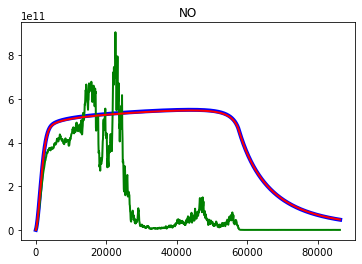

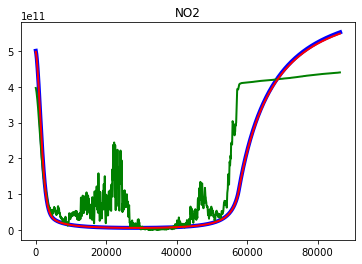

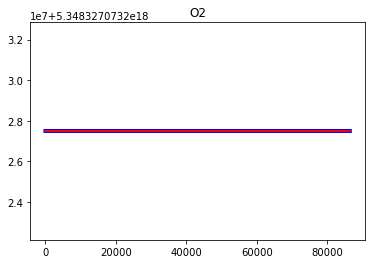

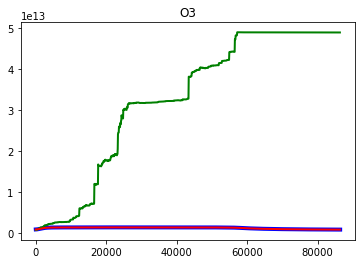

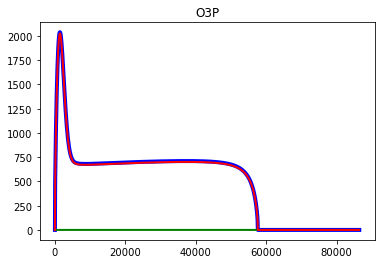

In [102]:
tDom=[tD[0] for tD in tmpTraj]
tDom1=[tD[0] for tD in tmpTraj1]
tDom2=[tD[0] for tD in tmpTraj2]
for spec in speciesNames:
    yDom=[tD[1][getElemInd[spec]] for tD in tmpTraj]
    yDom1=[tD[1][getElemInd[spec]] for tD in tmpTraj1]
    yDom2=[tD[1][getElemInd[spec]] for tD in tmpTraj2]
    plt.plot(tDom,yDom, linewidth = 4, color = 'blue') #legend='Exact'
    plt.plot(tDom1,yDom1, linewidth = 2, color = 'green') #legend='NoDA'
    plt.plot(tDom2,yDom2, linewidth = 2, color = 'red') #legend='DA'
    plt.title(spec)
    plt.show()
    


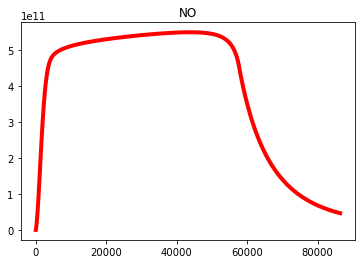

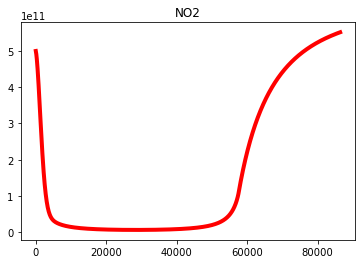

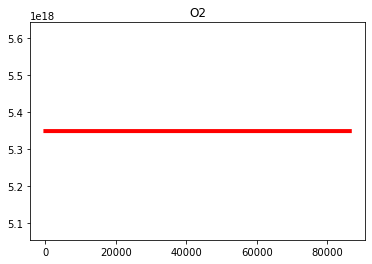

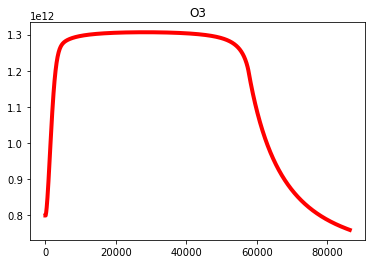

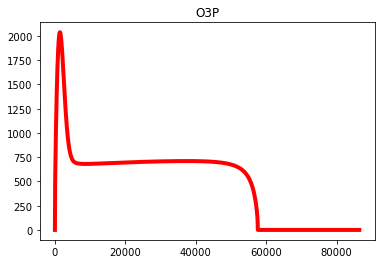

In [83]:
tDom=[tD[0] for tD in tmpTraj]
for spec in speciesNames:
    yDom=[tD[1][getElemInd[spec]] for tD in tmpTraj]
    plt.plot(tDom,yDom, linewidth = 4, color = 'red') #legend='Exact'
    plt.title(spec)
    plt.show()

In [56]:
del yDom[-1]

In [57]:
s=max(abs(np.array(yDom2)-np.array(yDom)))

In [58]:
s

11.490593307771178

In [26]:
len(np.array(yDom1))

12000

In [32]:
yDom2

[4.941943984833132e-34,
 4.941949793817722e-34,
 4.94195710043272e-34,
 4.941965870648279e-34,
 4.9419760595275915e-34,
 4.941987702497428e-34,
 4.942000692438103e-34,
 4.942015087652902e-34,
 4.942030920222738e-34,
 4.942048171099885e-34,
 4.942066771253773e-34,
 4.942086748305644e-34,
 4.942108128610381e-34,
 4.942130823011783e-34,
 4.942154884918542e-34,
 4.942180388462866e-34,
 4.942207208969887e-34,
 4.942235340248792e-34,
 4.9422648645422396e-34,
 4.942295724499317e-34,
 4.942327946892587e-34,
 4.942361496217763e-34,
 4.942396413967743e-34,
 4.942432603807582e-34,
 4.9424701755380875e-34,
 4.942509024672299e-34,
 4.942549203726813e-34,
 4.942590741533301e-34,
 4.942633586113793e-34,
 4.94267769837376e-34,
 4.942723097443439e-34,
 4.942769846887323e-34,
 4.942817818765152e-34,
 4.9428670771195446e-34,
 4.942917618069528e-34,
 4.94296943470299e-34,
 4.943022566657452e-34,
 4.9430769383650185e-34,
 4.943132564988126e-34,
 4.94318947103445e-34,
 4.943247595353513e-34,
 4.943306967954

In [6]:
Np=10

In [7]:
def normalization(weight):
    tic1 = time.perf_counter()
    S=np.sum(weight)
    weight=weight/S
    toc1 = time.perf_counter()
    print(f"Вычисление заняло {toc1 - tic1:0.4f} секунд")
    return weight

In [8]:
def A(Np):
    a=np.zeros(Np)
    for i in range(Np):
        a[i]=random.uniform(0,1)
    b=normalization(a)
    return b

In [9]:
A(Np)

Вычисление заняло 0.0001 секунд


array([0.01784357, 0.06753884, 0.16407575, 0.06125476, 0.09285467,
       0.22495274, 0.10612302, 0.0031704 , 0.19061422, 0.07157202])

In [10]:
def B(b):
    c=[]
    sum=0
    for i in range(Np):
        if i==0:
            c.append([0,b[0],b[0]])
        else:
            sum=sum+b[i-1]
            c.append([sum+10**(-20),sum+b[i],b[i]])
    return c

In [11]:
b=A(Np)
c=B(b)
print(c)

Вычисление заняло 0.0001 секунд
[[0, 0.04669252173742453, 0.04669252173742453], [0.04669252173742453, 0.07378074326514686, 0.02708822152772232], [0.07378074326514686, 0.232757908721314, 0.15897716545616714], [0.232757908721314, 0.2867584176331488, 0.05400050891183478], [0.2867584176331488, 0.47357218554023295, 0.18681376790708415], [0.47357218554023295, 0.6513656781474471, 0.17779349260721417], [0.6513656781474471, 0.6694331728565994, 0.018067494709152417], [0.6694331728565994, 0.7549313016270969, 0.0854981287704975], [0.7549313016270969, 0.8444886897521535, 0.08955738812505663], [0.8444886897521535, 0.9999999999999998, 0.15551131024784628]]


In [12]:
def C(c):
    index=[]
    d=[]
    for i in range(Np):
        a=random.uniform(0,1)
        for j in range(Np):
            if c[j][0]<=a and a<=c[j][1]:
                index.append(j)
                d.append(c[j][2])
    return [d,index]

In [13]:
b=A(Np)
print(b)
c=B(b)
C(c)

Вычисление заняло 0.0001 секунд
[0.05557778 0.0537149  0.19167362 0.01374056 0.07967766 0.10646006
 0.02118513 0.16988584 0.15228157 0.15580288]


[[0.19167361975396952,
  0.07967765935751012,
  0.053714903692238955,
  0.15580287911087506,
  0.1522815712498526,
  0.19167361975396952,
  0.053714903692238955,
  0.1522815712498526,
  0.16988583597353543,
  0.16988583597353543],
 [2, 4, 1, 9, 8, 2, 1, 8, 7, 7]]